/home/wagner/miniconda3/envs/xai4ecg/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load model..
all parameters have same shape


100%|██████████████████████████████████████████████████████████████████| 171/171 [00:01<00:00, 110.99it/s]


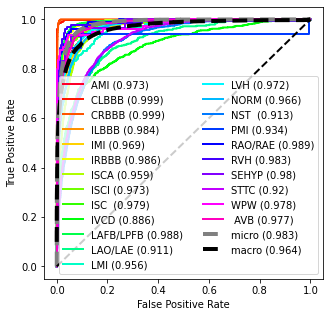

In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
import os
import sys
module_path = os.path.abspath(os.path.join('../code'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import utils
import torch 
from tqdm import tqdm

task='subdiagnostic'
modeltype='lenet'
segmentation_path = '../data/ptbxl/ptbxl_segmentations/'

signals,df,labels,model=utils.get_dataset_label_model(task=task, modeltype=modeltype)
predictions = utils.predict_samples(model, signals)

aucs = utils.multiclass_roc_curve(labels, predictions, utils.label_mappings[task])

In [2]:
import attribute_signals as attr
    
topN=100

method = 'gradient'
pathos = ['NORM','LVH', 'CLBBB', 'IMI', 'AMI']

relevances = []
all_patho_samples = []
all_predictions = []
all_labels = []
all_ids = []
masks = []
pidxs = []


for i, patho in enumerate(pathos):
    pidx = np.argwhere(np.array(utils.label_mappings[task]) == patho).flatten()[0]
    pidxs.append(pidx)
    
    # get topN predictions for pathology
    idxs = np.argsort(predictions[:,pidx])[::-1][:topN]
    all_ids.append(idxs)
    patho_only_mask = np.array([False]*len(predictions))
    patho_only_mask[idxs] = True

    masks.append(patho_only_mask)
    
    relevance = abs(attr.attribute_signals(
        model, 
        signals[idxs], 
        [pidx]*patho_only_mask.sum(), 
        labels.shape[-1], 
        modeltype, 
        method))
    
    relevances.append(relevance)
    all_predictions.append(predictions[patho_only_mask])
    all_labels.append(labels[patho_only_mask])
    all_patho_samples.append(signals[idxs])
all_patho_samples = np.array(all_patho_samples)
relevances = np.array(relevances)
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
relevances.shape, all_predictions.shape, all_labels.shape, all_patho_samples.shape

((5, 100, 1000, 12), (5, 100, 23), (5, 100, 23), (5, 100, 1000, 12))

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def get_map(x,s):
    return np.array([x[:,i].dot(s[:,i,:]) for i in range(x.shape[1])])/s.sum(axis=0)

def map_signal_and_attribution_with_fiducial(X,A,S):
    MA,MX=[],[]
    for i,x in tqdm(enumerate(X)):
        a = A[i]
        s = S[i]
        MA.append(get_map(a,s))
        MX.append(get_map(x,s))
    return np.array(MA), np.array(MX)


MAS,MXS = [],[]
for cidx in range(len(pathos)):
    segs = np.array([np.load(segmentation_path+str(df.iloc[idx].name)+'.npy', allow_pickle=True).astype(float)/255. for idx in all_ids[cidx]])
    MA, MX = map_signal_and_attribution_with_fiducial(all_patho_samples[cidx], abs(relevances[cidx]), segs)
    MAS.append(MA)
    MXS.append(MX)
MAS = np.array(MAS)
MXS = np.array(MXS)

100it [00:00, 649.95it/s]
100it [00:00, 408.00it/s]
100it [00:00, 407.87it/s]
100it [00:00, 407.23it/s]
100it [00:00, 390.23it/s]


100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6054.75it/s]


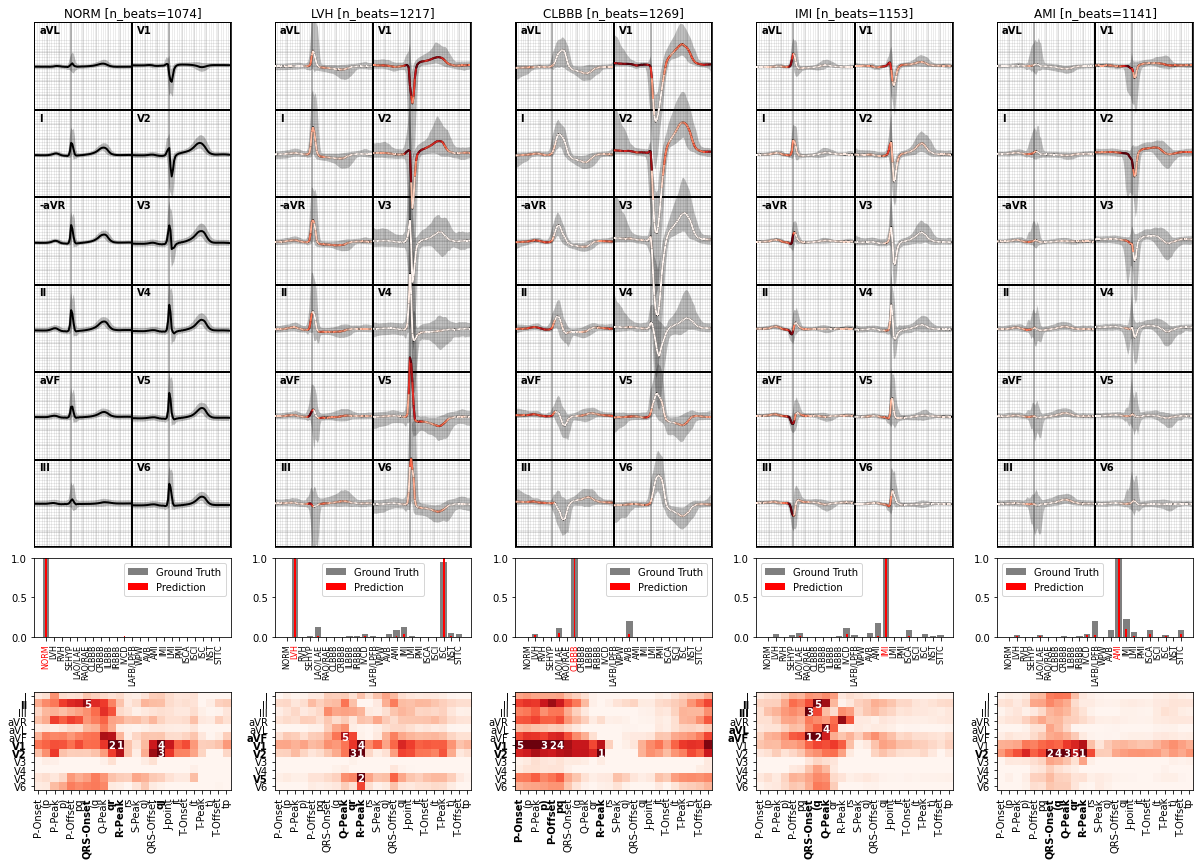

In [6]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.collections import LineCollection
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import plot_utils as pu

deli_map = {
    1:'P-Onset',
    2:'(p',
    3:'P-Peak',
    4:'p)',
    5:'P-Offset',
    6:'pq',
    7:'QRS-Onset',
    8:'(q',
    9:'Q-Peak',
    10:'qr',
    11:'R-Peak',
    12:'rs',
    13:'S-Peak',
    14:'q)',
    15:'QRS-Offset',
    16:'qj',
    17:'J-point',
    18:'jt',
    19:'T-Onset',
    20:'(t',
    21:'T-Peak',
    22:'t)',
    23:'T-Offset',
    24:'tp'   
}

def relevances_to_dataframe(relevances, patho):
    tmp_rel = {'Relevance':[], 'Lead':[], 'Pathology':[]}
    for j,tmp_relevance in enumerate(relevances):
        for i, lead in enumerate(tmp_relevance.T):
            tmp_rel['Relevance'].extend(lead[np.newaxis])
            tmp_rel['Lead'].extend([utils.leads[i]]*len(lead[np.newaxis]))
            tmp_rel['Pathology'].extend([patho]*len(lead[np.newaxis]))
    return pd.DataFrame(tmp_rel)

def normalize_spatial(data):
    return np.linalg.norm(np.array([abs(h)/np.linalg.norm(abs(h).flatten()) for h in data]), axis=1)

def normalize_temporal(data):
    return np.linalg.norm(np.array([abs(h)/np.linalg.norm(abs(h).flatten()) for h in data]), axis=-1)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def plot_predictions_and_labels_distro(pred, true, patho, ax):
   
    sidxs = [np.argwhere(np.array(utils.label_mappings[task]) == yi).flatten()[0] for yi in utils.subdiag_ordering]
    
    ax.bar(range(pred.shape[-1]), np.mean(true,axis=0)[sidxs], alpha=.5, color='k', label='Ground Truth')
    ax.bar(range(pred.shape[-1]), sigmoid(np.mean(pred,axis=0))[sidxs], alpha=1, color='r', width=.25, label='Prediction')
    ax.legend()
    xticks = [yi.replace('_', '') for yi in np.array(utils.label_mappings[task])[sidxs]]
    ax.set_xticks(range(pred.shape[-1]), xticks, rotation=90, fontsize=8)
    ax.set_ylim(0,1)

    for k, key in enumerate(xticks):
        if key == patho:
            ax.get_xticklabels()[k].set_color('r')
            


scale=1.123
offset=3
fig = plt.figure(constrained_layout=True, figsize=(3*len(pathos)*scale,10*scale))
subfigs = fig.subfigures(2, 1, height_ratios=[6, 3])
axs0 = subfigs[0].subplots(1,len(pathos))
axs1 = subfigs[1].subplots(2, len(pathos), gridspec_kw={'height_ratios':[1, 2]})

for i in range(len(pathos)):
    title = pathos[i]
    if pathos[i] == 'NORM':
        with_attributions=False
    else:
        with_attributions=True
    beats,heats,ids = pu.visualize_attributions(
        all_patho_samples[i], 
        abs(relevances[i]), 
        df.iloc[all_ids[i]], 
        title, 
        axis=axs0[i], 
        offset=offset,
        with_attributions=with_attributions)

    plot_predictions_and_labels_distro(all_predictions[i], all_labels[i], pathos[i], axs1[0,i])

    mma = np.mean(MAS[i],axis=0)
    vmaxa = np.quantile(abs(mma).flatten(), q=.99)
    vmina = np.quantile(abs(mma).flatten(), q=.2)
    im1=axs1[1,i].imshow(mma, cmap='Reds', vmin=vmina, vmax=vmaxa)

    if True:
        axs1[1,i].set_xticks(range(24), [deli_map[i+1] for i in range(24)], rotation=90)
        axs1[1,i].set_yticks(range(12), utils.leads)
        for j,idx in enumerate(np.dstack(np.unravel_index(np.argsort(mma.ravel())[::-1], (12, 24)))[0][:5]):
            axs1[1,i].text(idx[1],idx[0],str(j+1),color='w', ha='center', va='center', fontweight='bold')
            axs1[1,i].get_xticklabels()[idx[1]].set_fontweight('bold') 
            axs1[1,i].get_yticklabels()[idx[0]].set_fontweight('bold') 

plt.tight_layout()
plt.show()